In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate

In [2]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

## Part 0: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

![full_nlp_pipeline.png](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)
From [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [5]:
inputs = "I'm happy to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm happy to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  1372,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7811,  2.9486]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### 0.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [6]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
name = "distilbert/distilbert-base-cased"
# name = "user/name" when loading from
# name = local_path when using save_pretrained() method

tokenizer = DistilBertTokenizer.from_pretrained(name)      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained(name)  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained(name) # convenient! Defaults to Fast
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

DistilBertTokenizer(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=5

In [8]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is awesome!"
tokenized_inputs = tokenizer(input_str) # https://huggingface.co/learn/nlp-course/en/chapter6/6


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 14918, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 10289, 25267, 1110, 14918, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 14918, 106, 102]


In [9]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 Hugging Face Transformers is awesome!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'awesome', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 14918, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 14918, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is awesome! [SEP]


In [10]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(input_str)

print(input_str)
print("-"*5)
print(f"Number of tokens: {len(inputs)}")
print(f"Ids: {inputs.ids}")
print(f"Tokens: {inputs.tokens}")
print(f"Special tokens mask: {inputs.special_tokens_mask}")
print()
print("char_to_word gives the wordpiece of a character in the input")
char_idx = 8
print(f"For example, the {char_idx + 1}th character of the string is '{input_str[char_idx]}',"+\
      f" and it's part of wordpiece {inputs.char_to_token(char_idx)}, '{inputs.tokens[inputs.char_to_token(char_idx)]}'")

Hugging Face Transformers is awesome!
-----
Number of tokens: 9
Ids: [101, 20164, 10932, 10289, 25267, 1110, 14918, 106, 102]
Tokens: ['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'awesome', '!', '[SEP]']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 1]

char_to_word gives the wordpiece of a character in the input
For example, the 9th character of the string is 'F', and it's part of wordpiece 3, 'Face'


In [11]:
# Other cool tricks:
# The tokenizer can return pytorch tensors
model_inputs = tokenizer("Hugging Face Transformers is great!", return_tensors="pt")
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [12]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


In [13]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes."]


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 0.2 Models




Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
![model_illustration.png](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/transformer_and_head.svg)


Here are some examples.
```
*Model
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [14]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertModel
print('Loading base model')
base_model = DistilBertModel.from_pretrained('distilbert-base-cased')
print("Loading classification model from base model's checkpoint")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Loading base model


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Loading classification model from base model's checkpoint


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You can also initialize with random weights

In [22]:
from transformers import DistilBertConfig, DistilBertModel

# Initializing a DistilBERT configuration
configuration = DistilBertConfig()
configuration.num_labels=2
# Initializing a model (with random weights) from the configuration
model = DistilBertForSequenceClassification(configuration)

# Accessing the model configuration
configuration = model.config

We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [23]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110, 14918,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[0.0127, 0.0166]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward0>)


If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

These models are just Pytorch Modules! You can can calculate the loss with your `loss_func` and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used

In [24]:
# You can calculate the loss like normal
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

tensor(0.6912, grad_fn=<NllLossBackward0>)


('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0307, -0.0225,  0.0047,  ...,  0.0136,  0.0062,  0.0147],
         [ 0.0182,  0.0014,  0.0056,  ...,  0.0087,  0.0123,  0.0032],
         ...,
         [ 0.0111, -0.0073,  0.0168,  ...,  0.0255,  0.0079, -0.0132],
         [-0.0078, -0.0112, -0.0032,  ...,  0.0104, -0.0019,  0.0401],
         [-0.0413, -0.0156, -0.0119,  ...,  0.0278, -0.0039,  0.0060]],
        requires_grad=True))

Hugging Face provides an additional easy way to calculate the loss as well:

In [25]:
# To calculate the loss, we need to pass in a label:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)


print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

SequenceClassifierOutput(loss=tensor(0.6364, grad_fn=<NllLossBackward0>), logits=tensor([[-0.1565, -0.0396]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: POSITIVE


One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [26]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
# print(model_output)

Hidden state size (per layer):   torch.Size([1, 9, 768])
Attention head size (per layer): torch.Size([1, 12, 9, 9])


['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'awesome', '!', '[SEP]']


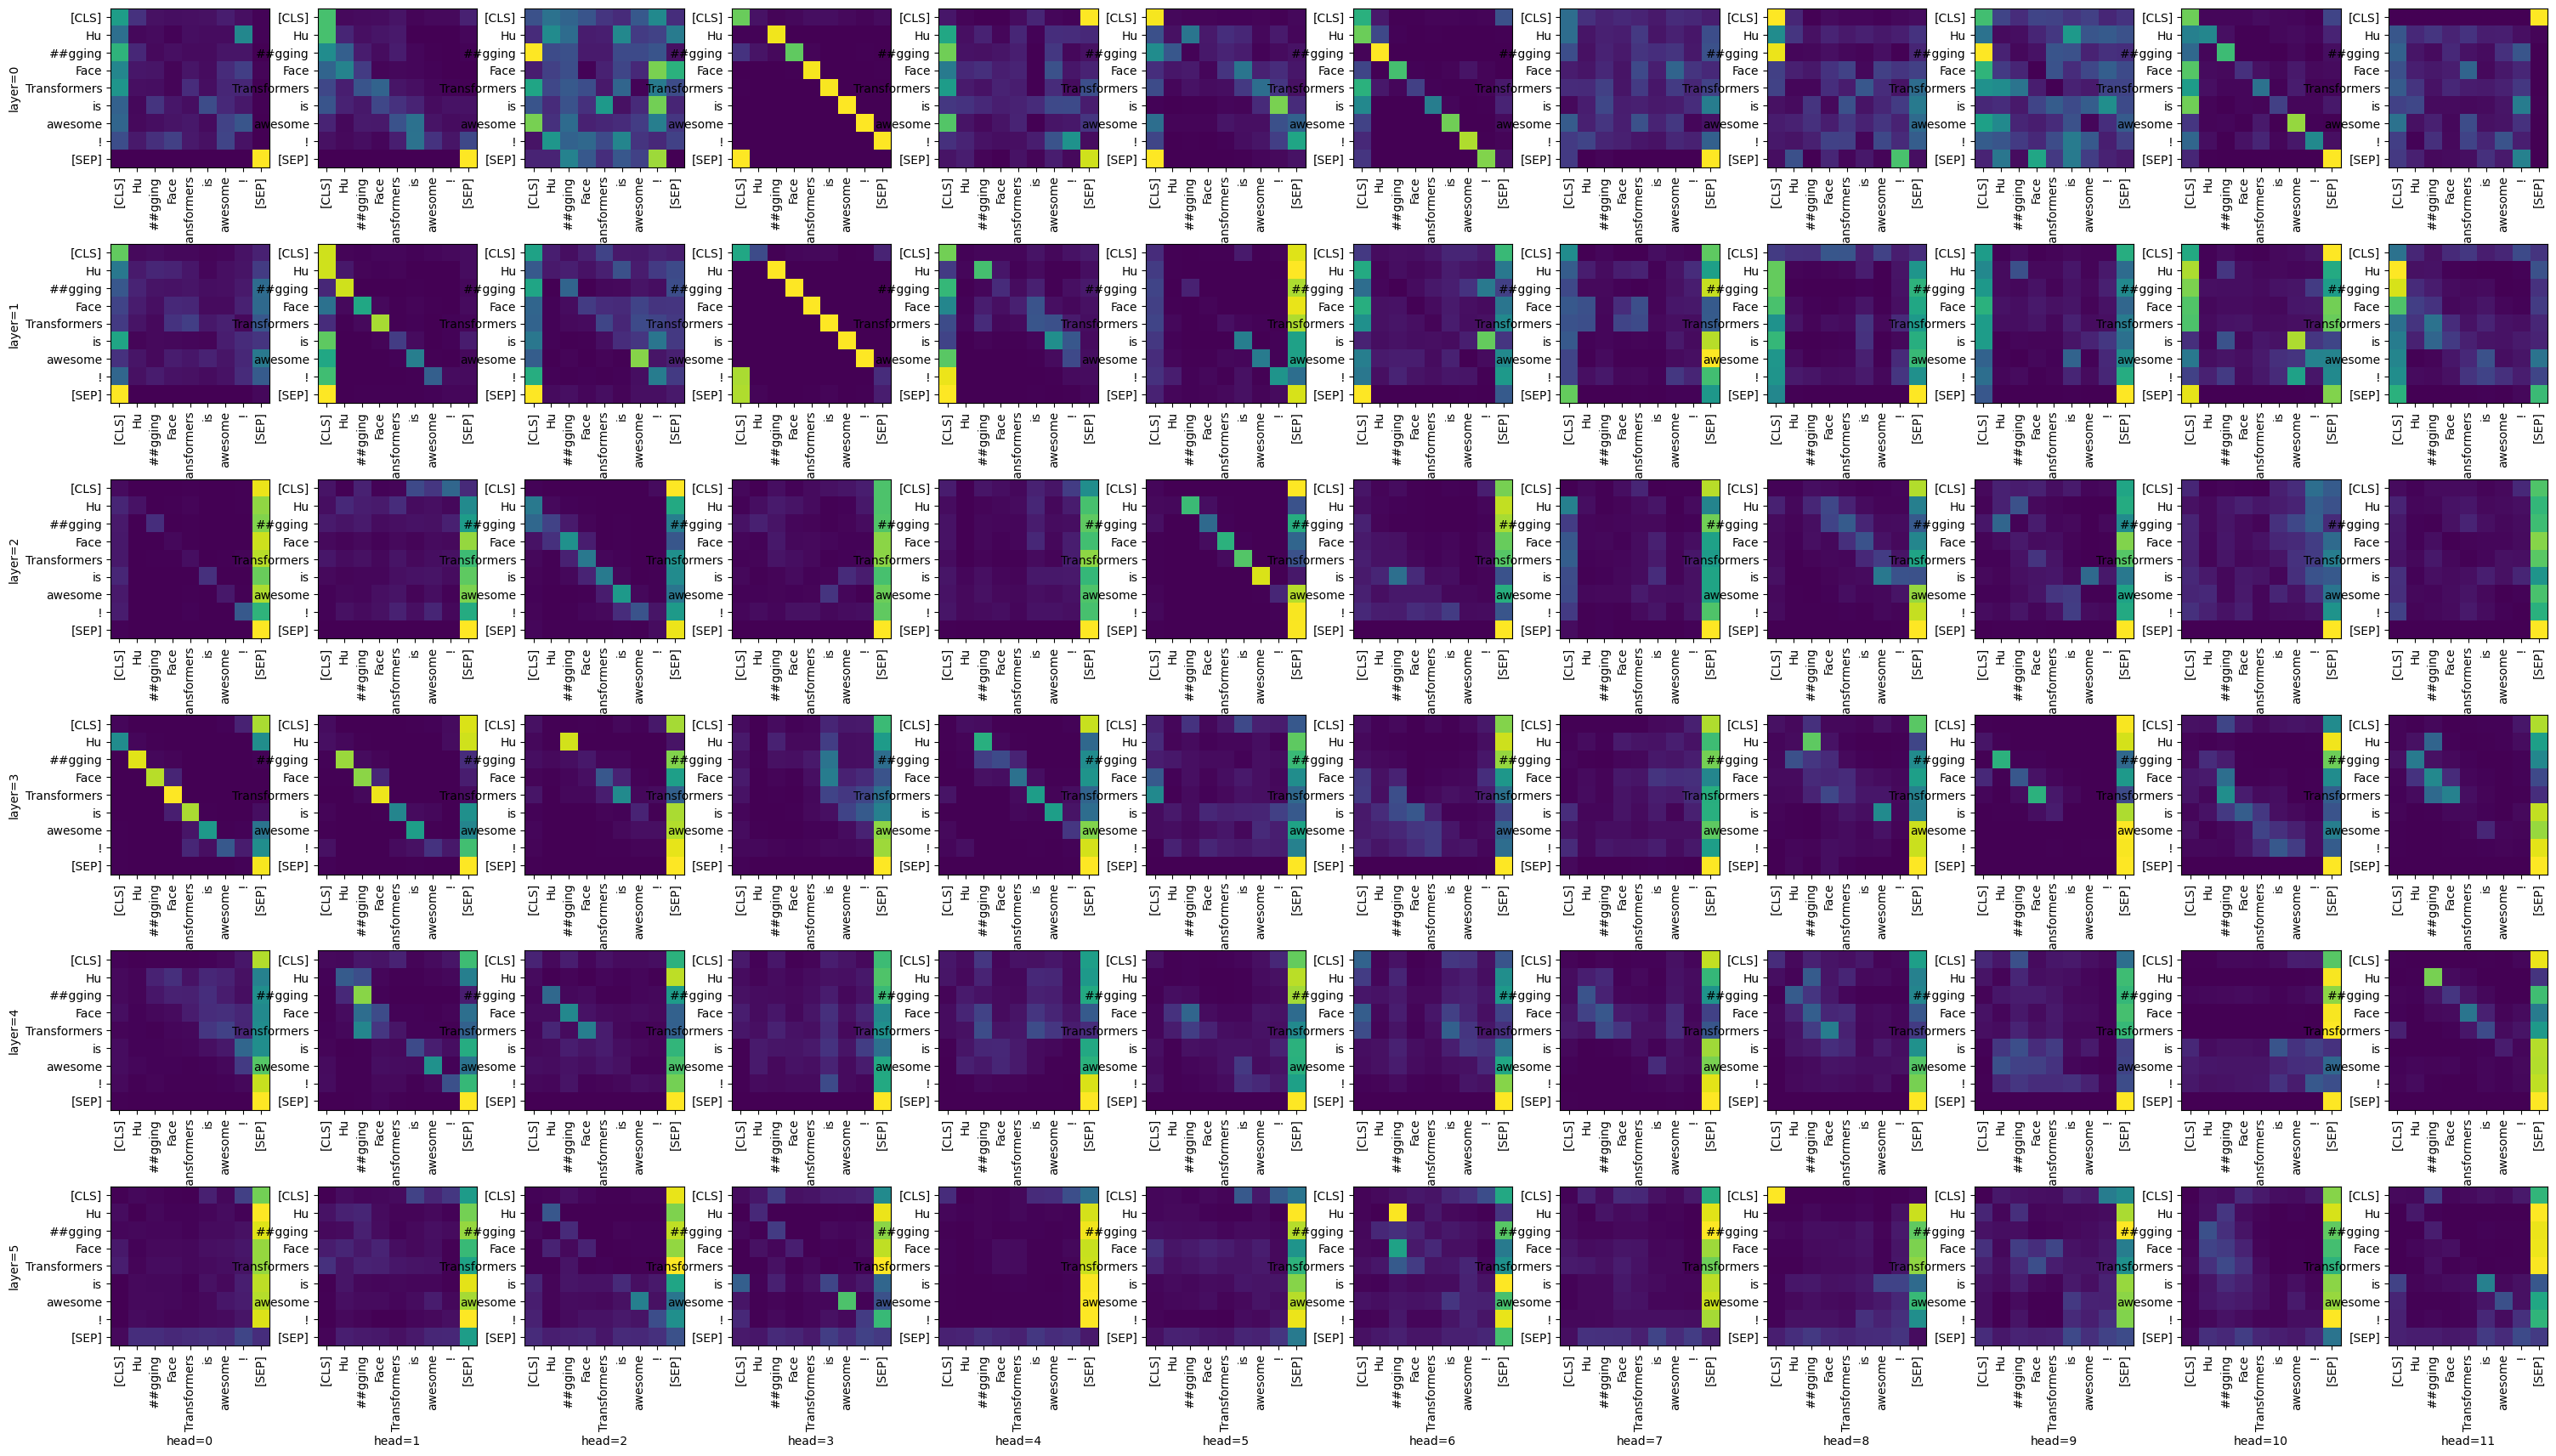

In [28]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Part 1: Finetuning

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.

### 2.1 Loading in a dataset

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets.

In [29]:
from datasets import load_dataset, DatasetDict



# DataLoader(zip(list1, list2))
dataset_name = "stanfordnlp/imdb"

imdb_dataset = load_dataset(dataset_name)


# Just take the first 50 tokens for speed/running on cpu
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

imdb_dataset

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [30]:

# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)
small_imdb_dataset

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32
    })
})

In [31]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

In [32]:
# Prepare the dataset - this tokenizes the dataset in batches of 16 examples.
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True), # https://huggingface.co/docs/transformers/pad_truncation
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [33]:
small_tokenized_dataset['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 Training

To train your models, you can just use the same kind of training loop that you would use in Pytorch. Hugging Face models are also `torch.nn.Module`s so backpropagation happens the same way and you can even use the same optimizers. Hugging Face also includes optimizers and learning rate schedules that were used to train Transformer models, so you can use these too.

For optimization, we're using the AdamW Optimizer, which is almost identical to Adam except it also includes weight decay.
And we're using a linear learning rate scheduler, which reduces the learning rate a little bit after each training step over the course of training.

There are other optimizers and learning rate schedulers you can use, but these are the default. If you want to explore, you can look at the ones [Hugging Face offers](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules), the ones available through [Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) (e.g. [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), which only decreases the learning rate when the validation loss stops decreasing), or write your own (like the one in Assignment 4).

In [39]:
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader # Import DataLoader


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

# Redefine dataloaders here to ensure they are in scope
train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

num_epochs = 1
num_training_steps = len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):

        # batch = ([text1, text2], [0, 1])

        output = model(**batch)

        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    # validation
    model.eval()
    loss = 0 # Initialize loss for validation
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss

    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'val_loss': best_val_loss,
        #     },
        #     f"checkpoints/epoch_{epoch}.pt"
        # )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.6738222241401672
Saving checkpoint!


In [40]:
batch['input_ids'].max()

tensor(27013)

While you can use PyTorch to train your models like we did in Assignment 4, Hugging Face offers a powerful `Trainer` class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend.

In [41]:
imdb_dataset = load_dataset("stanfordnlp/imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping,
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [52]:
import os
os.environ["WANDB_DISABLED"] = "true" # Disable Weights & Biases logging entirely for this session

from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    eval_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224,
    report_to="none" # Explicitly disable Weights & Biases logging
)

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1797445872.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [53]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
    # will call on_log on each logging step, specified by TrainerArguement. (i.e TrainerArguement.logginng_step)
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")
    # def on_epoch(...)


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

In [54]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.692766,0.437500
2,No log,0.688797,0.437500


TrainOutput(global_step=16, training_loss=0.6890949010848999, metrics={'train_runtime': 24.0053, 'train_samples_per_second': 10.664, 'train_steps_per_second': 0.667, 'train_loss': 0.6890949010848999, 'epoch': 2.0})

In [55]:
# evaluating the model is very easy

# results = trainer.evaluate()                           # just gets evaluation metrics
results = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

In [56]:
results

PredictionOutput(predictions=array([[ 0.02465075, -0.03071576],
       [ 0.00566426, -0.05353779],
       [ 0.01187114, -0.02595498],
       [ 0.02408076, -0.06696652],
       [ 0.01749077,  0.00506206],
       [ 0.03717888, -0.0480109 ],
       [ 0.04144429, -0.05054434],
       [ 0.03477689, -0.02630729],
       [ 0.02318155,  0.00515435],
       [ 0.00115409, -0.02727072],
       [ 0.01004235, -0.03218793],
       [ 0.04509781, -0.05876866],
       [ 0.03968845, -0.06491617],
       [-0.00500716, -0.04906449],
       [ 0.04025566, -0.05683028],
       [ 0.05332864, -0.06152529],
       [ 0.08603527, -0.07024246],
       [-0.00285626, -0.0346669 ],
       [ 0.00433015, -0.04509469],
       [ 0.00251326,  0.00097555],
       [ 0.0517775 , -0.06208421],
       [ 0.02654287, -0.04562202],
       [ 0.0215385 , -0.03398664],
       [ 0.0239429 , -0.03491711],
       [ 0.03865421, -0.01836816],
       [ 0.01343334, -0.02025495],
       [ 0.00545343, -0.02941992],
       [ 0.02857236, -0.00

In [57]:
# To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:
test_str = "I enjoyed the movie!"

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-8")
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

NEGATIVE


Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}
* Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
* weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

## Appendix 0: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [58]:
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [59]:
prompt = "Once upon a time"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1) Once upon a time the question was answered, this is the answer to the question, as this would be a good idea if it were answered with a simple but informative, simple answer.

One of the more powerful questions that we often hear from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2) Once upon a time we were already on a pretty bad track as we started to think of all the new things in the series, and I was so amazed by it. We hadn't been going all that far, but I did start to think a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3) Once upon a time of my own. But I was thinking, how could we go about that? How could we really build a place for me?‧ … Why would we need a lot of people to give me some space to work?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4) Once upon a time, you could do something special, or you could write something that took place before.”


That” was what made a really powerful piece of art.
It” meant something that could even be seen


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5) Once upon a time of such great growth and demand that an unprecedented increase in the amount of food consumed, a growing number of people are being encouraged to buy a cup of coffee or even an espresso to take a nap, when they are not being fed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6) Once upon a time I found it more and more difficult for me to take over the management of the organization. It was a lot easier for me to leave, but after this experience, I found that it was a more difficult situation for me to take


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7) Once upon a time a woman in a state of mourning was killed or killed or killed while riding a motorized motorcycle in the county of New Hampshire, or for carrying an adult firearm in a vehicle, it was the duty of those drivers to enforce those


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8) Once upon a time in the early 20th century, as it was often called, some people took to Twitter to call themselves the “‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9) Once upon a time of year, that's not a bad thing for a bird of prey, but if you look at the numbers that bird populations now have, you'd see that the biggest birds are in Alaska, Alaska, Alaska, and most of
10) Once upon a time of war, the Japanese government was able to achieve its objectives without any difficulty.

The Japanese government in 1941 provided the first major military victory against the Japanese, and they had defeated the Japanese military with a huge victory in the




```
# This is formatted as code
```

## Appendix 1: Pipelines

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface.

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Sentiment Analysis:

In [61]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Device set to use cuda:0


You can run the pipeline by just calling it on a string

In [62]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

Or on a list of strings:

In [63]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)

## Appendix 2: Masked Language Modeling

In [64]:
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
prompt = "I am [MASK] to learn about HuggingFace!"
model = pipeline("fill-mask", "bert-base-cased")
model(prompt)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[{'score': 0.3552875518798828,
  'token': 7215,
  'token_str': 'excited',
  'sequence': 'I am excited to learn about HuggingFace!'},
 {'score': 0.1562105119228363,
  'token': 1280,
  'token_str': 'going',
  'sequence': 'I am going to learn about HuggingFace!'},
 {'score': 0.07893422991037369,
  'token': 9582,
  'token_str': 'eager',
  'sequence': 'I am eager to learn about HuggingFace!'},
 {'score': 0.03559931740164757,
  'token': 1303,
  'token_str': 'here',
  'sequence': 'I am here to learn about HuggingFace!'},
 {'score': 0.035240620374679565,
  'token': 17261,
  'token_str': 'delighted',
  'sequence': 'I am delighted to learn about HuggingFace!'}]

In [66]:
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top_5_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(5)

print(prompt)
for i in range(5):
    prediction = tokenizer.decode(top_5_predictions.indices[0, i])
    prob = top_5_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")

I am [MASK] to learn about HuggingFace!
  1) excited	0.355
  2) going	0.156
  3) eager	0.079
  4) here	0.036
  5) delighted	0.035
